<a href="https://colab.research.google.com/github/mx-drn/bachelor_thesis_pseudo_labeling/blob/main/complete_bachelor_thesis_notebook_on_kaggle_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
#!pip install wandb
!pip install easynmt
#!pip install pytorch-pretrained-bert pytorch-nlp
!pip install wordcloud
!pip install niacin

In [2]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

In [3]:
#print(torch.__version__)

In [4]:
# needed imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import nltk
import time
#import wandb
import pickle
from easynmt import EasyNMT
import requests
import copy
import collections
from collections import defaultdict
from operator import itemgetter
import pickle
import string
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import plotly.express as px

import transformers
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from textwrap import wrap
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from transformers.models.bert.modeling_bert import BertEmbeddings, BertPooler, BertLayer
#import pytorch_lightning as pl
from sklearn.feature_extraction.text import CountVectorizer
from niacin.text import en

from pylab import rcParams
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# Use GPU
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Sun Aug 15 12:40:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get an Overview over the data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# import data
data_loaded = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/kaggle_data.csv", names=['label', 'article'], encoding='latin-1')
data = data_loaded.copy()
print("Overall distribution of the data and labels:")
print(data['label'].value_counts(ascending=True))
print()
data.drop_duplicates()

all_lens = {
    'positive': [],
    'negative': [],
    'neutral': []
}

for index, row in data.iterrows():
    all_lens[row['label']].append(len(row['article']))
print("General dataset size: " + str(len(data)))

print("\nPositive Sentiment Mean Article Length: " + str(sum(all_lens['positive'])/len(all_lens['positive'])))
print("Positive Sentiment Max Article Length: " + str(max(all_lens['positive'])))
print()
print("Neutral Sentiment Mean Article Length: " + str(sum(all_lens['neutral'])/len(all_lens['neutral'])))
print("Neutral Sentiment Max Article Length: " + str(max(all_lens['neutral'])))
print()
print("Negative Sentiment Mean Article Length: " + str(sum(all_lens['negative'])/len(all_lens['negative'])))
print("Negative Sentiment Max Article Length: " + str(max(all_lens['negative'])))

Overall distribution of the data and labels:
negative     604
positive    1363
neutral     2879
Name: label, dtype: int64

General dataset size: 4846

Positive Sentiment Mean Article Length: 135.64783565663976
Positive Sentiment Max Article Length: 298

Neutral Sentiment Mean Article Length: 125.07224730809308
Neutral Sentiment Max Article Length: 315

Negative Sentiment Mean Article Length: 125.75662251655629
Negative Sentiment Max Article Length: 296


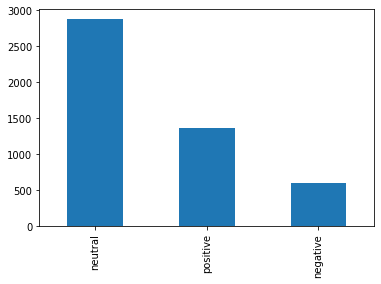

In [8]:
# Plot data distribution
data['label'].value_counts().plot(kind='bar')

## Apply over and under sampling


positive    604
neutral     604
negative    604
Name: label, dtype: int64


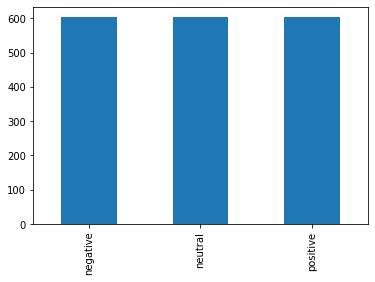

In [9]:
count_dict = {
        'positive': len(data[data['label'] == 'positive']),
        'neutral': len(data[data['label'] == 'neutral']),
        'negative': len(data[data['label'] == 'negative'])
    }

# As we see in the plot above: underfit neutral to size of positive and oversample negative to size of positive
data_goal_size = data[data.label=='positive']
data_to_undersample1 = data[data.label=='positive']
data_to_undersample2 = data[data.label=='neutral']

data_undersampled1 = resample(data_to_undersample1, 
                            replace=False,
                            n_samples=count_dict['negative'],
                            random_state=1210)

data_undersampled2 = resample(data_to_undersample2, 
                              replace=True,
                              n_samples=count_dict['negative'],
                              random_state=1210)

# Concat dataframes
data = pd.concat([data[data['label'] == 'negative'], data_undersampled1, data_undersampled2])
data.reset_index(inplace=True, drop=True)

data['label'].value_counts().plot(kind='bar')
print(data['label'].value_counts(ascending=True))

## Have a look at the data

In [10]:
print('Article:')
print(data.iloc[13].article + "\n")
print('Label:')
print(data.iloc[13].label)

Article:
23 April 2010 - Finnish construction and engineering company Outotec Oyj HEL : OTE1V said today it slipped to a net loss of EUR7 .3 m in the first quarter of 2010 from a net profit of EUR12 .5 m in the corresponding period last year .

Label:
negative


In [11]:
label_names = list(set(data['label'].values))
label_names.sort()

print("All possible labels: " + str(label_names))

All possible labels: ['negative', 'neutral', 'positive']


### Test Data if BERT cased or uncased makes sense

In [12]:
uppercased_words_found = []

for index, row in data.iterrows():
    temp_article = row['article']
    
    for word in temp_article:
        if len(word)>1 and word == word.upper():
            uppercased_words_found.append(word)
            
print(uppercased_words_found)

[]


## Preprocessing (@author: https://www.kaggle.com/madz2000/sentiment-analysis-cleaning-eda-bert-88-acc)

In [13]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
data['article']=data['article'].apply(remove_special_characters)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
    
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Apply function on review column
data['article']=data['article'].apply(denoise_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Wordclouds

### Overall

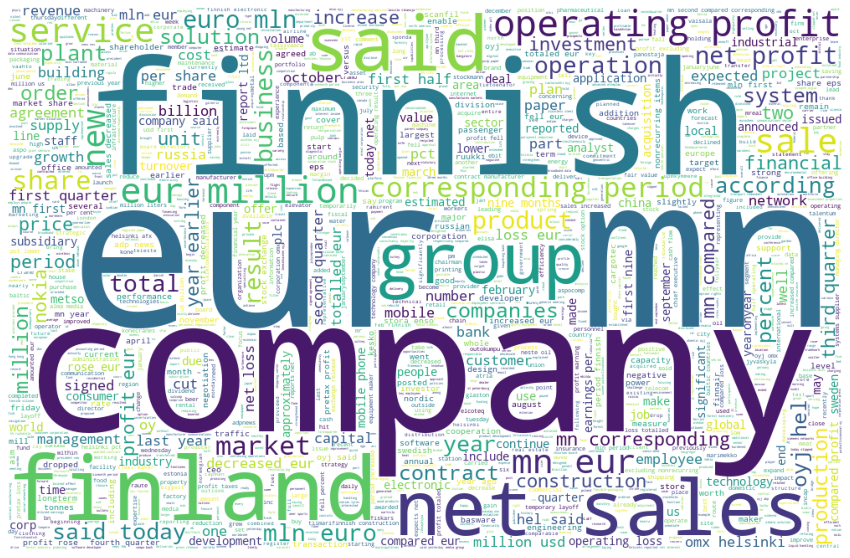

In [14]:
words_collection = collections.Counter([item for item in data['article']])

word_string = " ".join(words_collection)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=1500, 
                      width=1000,
                      height=650
                         ).generate(word_string)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Positive articles

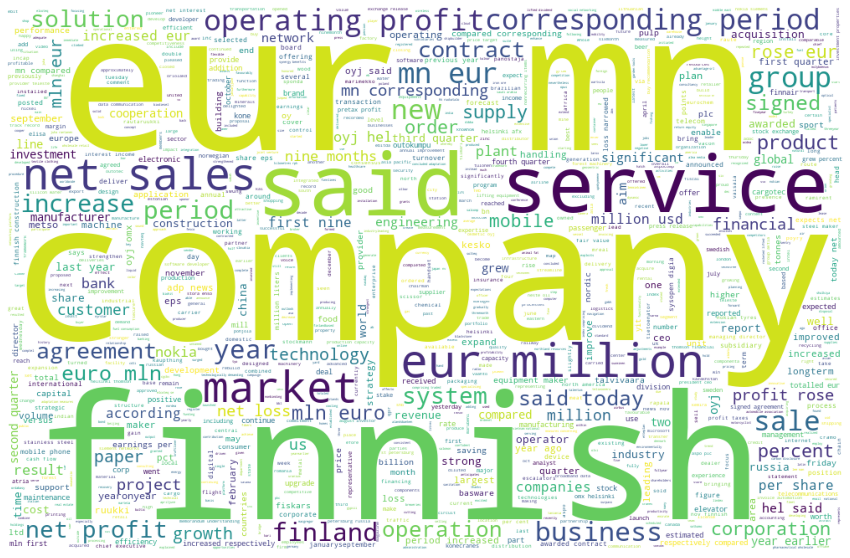

In [15]:
positives = data[data['label'] == 'positive']

words_collection = collections.Counter([item for item in positives['article']])

word_string = " ".join(words_collection)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=1500, 
                      width=1000,
                      height=650
                         ).generate(word_string)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Neutral articles


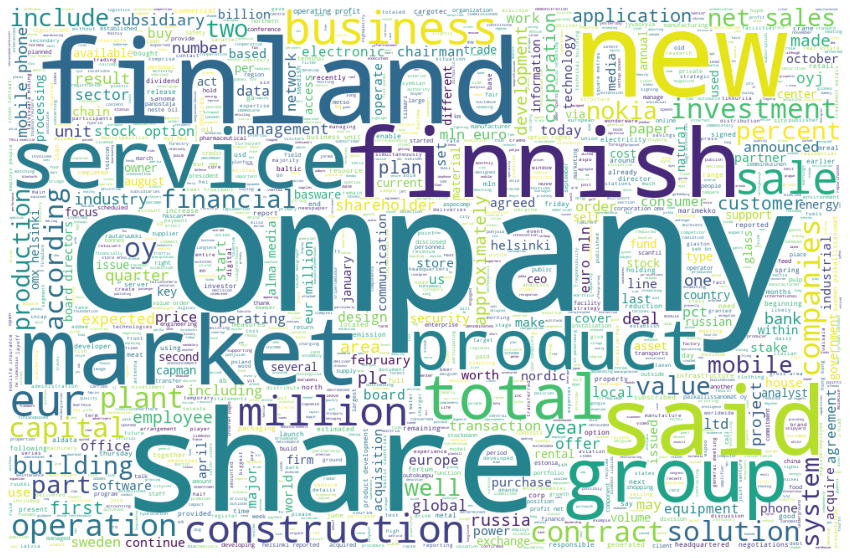

In [16]:
neutrals = data[data['label'] == 'neutral']

words_collection = collections.Counter([item for item in neutrals['article']])

word_string = " ".join(words_collection)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=1500, 
                      width=1000,
                      height=650
                         ).generate(word_string)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Negative articles

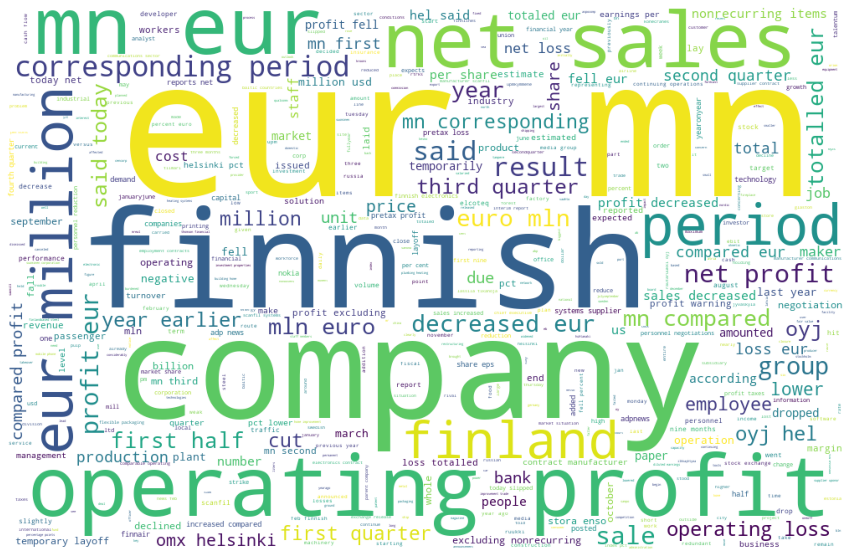

In [17]:
negatives = data[data['label'] == 'negative']

words_collection = collections.Counter([item for item in negatives['article']])

word_string = " ".join(words_collection)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=1500, 
                      width=1000,
                      height=650
                         ).generate(word_string)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Analyze distribution of review size in the context of positive or negative labels

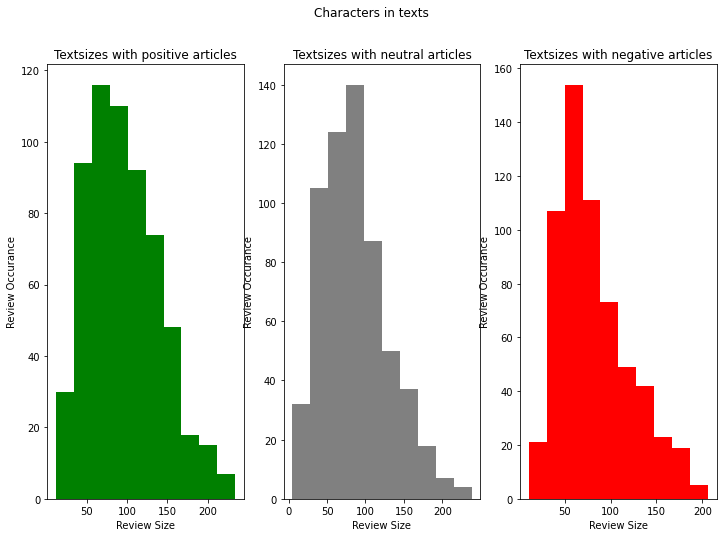

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))

text_len = data[data['label'] == 'positive']['article'].str.len()
ax1.hist(text_len, color='green')
ax1.set_title('Textsizes with positive articles')
ax1.set_xlabel("Review Size")
ax1.set_ylabel("Review Occurance")

text_len = data[data['label'] == 'neutral']['article'].str.len()
ax2.hist(text_len, color='grey')
ax2.set_title('Textsizes with neutral articles')
ax2.set_xlabel("Review Size")
ax2.set_ylabel("Review Occurance")

text_len = data[data['label'] == 'negative']['article'].str.len()
ax3.hist(text_len, color='red')
ax3.set_title('Textsizes with negative articles')
ax3.set_xlabel("Review Size")
ax3.set_ylabel("Review Occurance")

fig.suptitle('Characters in texts')

plt.show()

## Analyze most occuring Trigram -> three words pair occuring together in the same reqiew

In [19]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

most_common_tri = get_top_text_ngrams(data.article,20,3)
most_common_tri = dict(most_common_tri)

temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())

fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')

fig.show()

### Delete words "mn", "mln" and "eur" from articles, as the amount is not important for sentiment and it reduces confusion about sentiments

In [20]:
data['article']=data['article'].apply(lambda x: x.replace("mn", "").replace("eur", "").replace("mln", ""))

most_common_tri = get_top_text_ngrams(data.article,20,3)
most_common_tri = dict(most_common_tri)

temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())

fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')

fig.show()

## Convert labels to more understandable 0, 1, 2 format

In [21]:
data.label.replace("positive" , 2 , inplace = True)
data.label.replace("neutral" , 1 , inplace = True)
data.label.replace("negative" , 0 , inplace = True)

## Build Pseudo Labeling Dataset

In [22]:
# method to get exactly 50, 100, ... labeled data
def get_dataclass_distribution_of_unlabeled_data(data_class_size, X, y, random_state):
  labeled_data_distribution = data_class_size/len(X)

  X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X, y, test_size=labeled_data_distribution, random_state=random_state, stratify=y)
  len(X_labeled)
  return {
      'labeled_data': X_labeled,
      'labeled_data_labels': y_labeled,
      'unlabeled_data': X_unlabeled,
      'unlabeled_data_labels': y_unlabeled
  }

## Set tokenizer

In [23]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
# Uncased -> Because case may express the sentiment but no uppercase word are given in the dataset as mentioned earlier

### Choose maximum token length

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



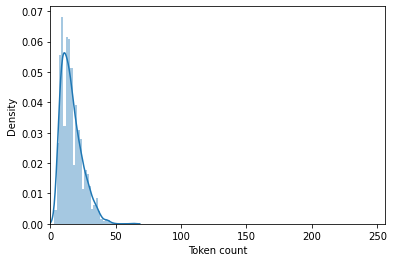

In [24]:
token_lens = []
for txt in data.article:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [25]:
MAX_LEN = 70
BATCH_SIZE = 8
SEED = 1210

# Split data into training and validation datasets

In [26]:

def split_data_into_train_test_val(X, y, val_size, random_state):
    X_reduced, X_test, y_reduced, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_reduced, y_reduced, test_size=val_size, random_state=random_state, stratify=y_reduced)
    
    return {
        'train': {
            'X': list(X_train),
            'y': list(y_train)
        },
        'val': {
            'X': list(X_val),
            'y': list(y_val)
        },
        'test': {
            'X': list(X_test),
            'y': list(y_test)
        }
    }

In [27]:
split_data = split_data_into_train_test_val(data['article'].values, data['label'].values, val_size=0.2, random_state=SEED)

In [28]:
X_train = split_data['train']['X']
X_test = split_data['test']['X']
X_val = split_data['val']['X']
y_train = split_data['train']['y']
y_test = split_data['test']['y']
y_val = split_data['val']['y']

import collections, numpy



print("Distribution train: ")
print(collections.Counter(y_train))
print("\nDistribution val: ")
print(collections.Counter(y_val))
print("\nDistribution test: ")
print(collections.Counter(y_test))

Distribution train: 
Counter({0: 435, 2: 435, 1: 434})

Distribution val: 
Counter({0: 109, 1: 109, 2: 108})

Distribution test: 
Counter({2: 61, 1: 61, 0: 60})


### Build data class for pytorch-Dataloader usage (Map-style dataset)

In [29]:
class BertData():
    def __init__(self, article, label):
        self.article = article
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.article)
    
    def __getitem__(self, idx):
        article = str(self.article[idx])
        article = ' '.join(article.split())

        inputs = self.tokenizer.encode_plus(
            article,
            None,
            add_special_tokens = True,
            max_length = MAX_LEN,
            padding='max_length',
            truncation='longest_first'
        )

        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        labels = torch.tensor(self.label[idx], dtype=torch.long)

        return {'article': article,
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'targets': labels
                }

In [30]:
training_set = BertData(article=X_train, label=y_train)
validation_set = BertData(article=X_val, label=y_val)
test_set = BertData(article=X_test, label=y_test)

### Set pytorch data loader

In [31]:
def get_dataloader(training_set, validation_set, test_set):
    train_dataloader = DataLoader(
            training_set,
            batch_size=BATCH_SIZE, 
            shuffle=True
            )
    val_dataloader = DataLoader(
            validation_set,
            shuffle=False,
            batch_size=BATCH_SIZE
            )
    test_dataloader = DataLoader(
            test_set,
            shuffle=False,
            batch_size=BATCH_SIZE
            )
    
    return train_dataloader, val_dataloader, test_dataloader

# BERT Model

## Build PyTorch Pipeline

In [32]:
#train_dataloader, val_dataloader, test_dataloader = get_dataloader(X_train, y_train, X_val, y_val, X_test, y_test)

## Set Hyperparameters

In [33]:
EPOCHS = 10
VALIDATION_SPLIT = 0.2
learning_rate = 3e-5

## Define standard BERT Classifier

In [34]:
class ClassicalBertClassifier(nn.Module):
    def __init__(self):
        super(ClassicalBertClassifier, self).__init__()
        
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        #for param in self.bert.parameters():
         # param.requires_grad = False
        #self.drop = nn.Dropout(0.3)
        
#        self.classifier = nn.Sequential(
 #           nn.Linear(768, 384),
  #          #nn.ReLU(),
   #         nn.Tanh(),
    #        nn.Dropout(0.3),
     #       nn.Linear(384, 128),
      #      nn.Tanh(),
       #     nn.Dropout(0.4),
        #    nn.Linear(128, 3)
       # )

#        self.classifier = nn.Sequential(
 #           nn.Linear(768, 384),
  #          nn.ReLU(),
   #        nn.Dropout(0.5),
    #       nn.Linear(384, 3)
     #  )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(768, 3)
        )
        #self.all_targets = []


    def forward(self, input_ids, attention_mask, token_type_ids) -> torch.Tensor:
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

    

# MixTest

## Define MixText BERT Classifier (According to publishers)

In [35]:
class BertModel4Mix(transformers.BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel4Mix, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder4Mix(config)
        self.pooler = BertPooler(config)

        self.init_weights()

    def _resize_token_embeddings(self, new_num_tokens):
        old_embeddings = self.embeddings.word_embeddings
        new_embeddings = self._get_resized_embeddings(
            old_embeddings, new_num_tokens)
        self.embeddings.word_embeddings = new_embeddings
        return self.embeddings.word_embeddings

    def _prune_heads(self, heads_to_prune):
        """ Prunes heads of the model.
            heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
            See base class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(self, input_ids,  input_ids2=None, l=None, mix_layer=1000, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):

        if attention_mask is None:
            if input_ids2 is not None:
                attention_mask2 = torch.ones_like(input_ids2)
            attention_mask = torch.ones_like(input_ids)

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
            if input_ids2 is not None:
                token_type_ids2 = torch.zeros_like(input_ids2)

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        if input_ids2 is not None:

            extended_attention_mask2 = attention_mask2.unsqueeze(
                1).unsqueeze(2)

            extended_attention_mask2 = extended_attention_mask2.to(
                dtype=next(self.parameters()).dtype)  # fp16 compatibility
            extended_attention_mask2 = (
                1.0 - extended_attention_mask2) * -10000.0

        if head_mask is not None:
            if head_mask.dim() == 1:
                head_mask = head_mask.unsqueeze(0).unsqueeze(
                    0).unsqueeze(-1).unsqueeze(-1)
                head_mask = head_mask.expand(
                    self.config.num_hidden_layers, -1, -1, -1, -1)
            elif head_mask.dim() == 2:
                # We can specify head_mask for each layer
                head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)
            # switch to fload if need + fp16 compatibility
            head_mask = head_mask.to(dtype=next(self.parameters()).dtype)
        else:
            head_mask = [None] * self.config.num_hidden_layers

        embedding_output = self.embeddings(
            input_ids, position_ids=position_ids, token_type_ids=token_type_ids)

        if input_ids2 is not None:
            embedding_output2 = self.embeddings(
                input_ids2, position_ids=position_ids, token_type_ids=token_type_ids2)

        if input_ids2 is not None:
            encoder_outputs = self.encoder(embedding_output, embedding_output2, l, mix_layer,
                                           extended_attention_mask, extended_attention_mask2, head_mask=head_mask)
        else:
            encoder_outputs = self.encoder(
                embedding_output, attention_mask=extended_attention_mask, head_mask=head_mask)

        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)

        # add hidden_states and attentions if they are here
        outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]
        # sequence_output, pooled_output, (hidden_states), (attentions)
        return outputs

## Define BERT Encoder for Mix Test

In [36]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class BertEncoder4Mix(nn.Module):
    def __init__(self, config):
        super(BertEncoder4Mix, self).__init__()
        self.output_attentions = config.output_attentions
        self.output_hidden_states = config.output_hidden_states
        self.layer = nn.ModuleList([BertLayer(config)
                                    for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, hidden_states2=None, l=None, mix_layer=1000, attention_mask=None, attention_mask2=None, head_mask=None):
        all_hidden_states = ()
        all_attentions = ()

        # Perform mix at till the mix_layer
        if mix_layer == -1:
            if hidden_states2 is not None:
                hidden_states = l * hidden_states + (1-l)*hidden_states2

        for i, layer_module in enumerate(self.layer):
            if i <= mix_layer:

                if self.output_hidden_states:
                    all_hidden_states = all_hidden_states + (hidden_states,)

                layer_outputs = layer_module(
                    hidden_states, attention_mask, head_mask[i])
                hidden_states = layer_outputs[0]

                if self.output_attentions:
                    all_attentions = all_attentions + (layer_outputs[1],)

                if hidden_states2 is not None:
                    layer_outputs2 = layer_module(
                        hidden_states2, attention_mask2, head_mask[i])
                    hidden_states2 = layer_outputs2[0]

            if i == mix_layer:
                if hidden_states2 is not None:
                    hidden_states = l * hidden_states + (1-l)*hidden_states2

            if i > mix_layer:
                if self.output_hidden_states:
                    all_hidden_states = all_hidden_states + (hidden_states,)

                layer_outputs = layer_module(
                    hidden_states, attention_mask, head_mask[i])
                hidden_states = layer_outputs[0]

                if self.output_attentions:
                    all_attentions = all_attentions + (layer_outputs[1],)

        # Add last layer
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            outputs = outputs + (all_attentions,)
        # last-layer hidden state, (all hidden states), (all attentions)
        return outputs


## Define Mix Test

In [37]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class MixText(nn.Module):
    def __init__(self, num_labels=3, mix_option=False):
        super(MixText, self).__init__()

        if mix_option:
            self.bert = BertModel4Mix.from_pretrained('bert-base-uncased')
        else:
            self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        self.linear = nn.Sequential(nn.Linear(768, 128),
                                    nn.Tanh(),
                                    nn.Linear(128, num_labels))

    def forward(self, x, x2=None, l=None, mix_layer=1000):

        if x2 is not None:
            all_hidden, pooler = self.bert(x, x2, l, mix_layer)

            pooled_output = torch.mean(all_hidden, 1)

        else:
            all_hidden, pooler = self.bert(x)

            pooled_output = torch.mean(all_hidden, 1)

        predict = self.linear(pooled_output)

        return predict

## Define Mix Validate

In [38]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
def mix_validate(valloader, model, criterion, epoch, mode):
    model.eval()
    with torch.no_grad():
        loss_total = 0
        total_sample = 0
        correct = 0
        overall_targets = []
        overall_preds = []

        for batch_idx, (inputs, targets, length) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs.data, 1)

            if batch_idx == 0:
                print("Sample some true labeles and predicted labels")
                print(predicted[:20])
                print(targets[:20])

            new_targets = [int(target) for target in targets]
            overall_targets = overall_targets + new_targets

            new_preds = [int(pred) for pred in predicted]
            overall_preds = overall_preds + new_preds

            loss_total += loss.item() * inputs.shape[0]
            total_sample += inputs.shape[0]

        loss_total = loss_total/total_sample
        
    accuracy = accuracy_score(overall_targets, overall_preds)
    precision = precision_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
    recall = recall_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
    f1 = f1_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))

    frequency = {}

    # iterating over the list
    for item in overall_preds:
    # checking the element in dictionary
      if item in frequency:
        # incrementing the count
        frequency[item] += 1
      else:
      # initializing the count
        frequency[item] = 1

    frequency = dict(sorted(frequency.items(), key=lambda item: item[1]))

    return loss_total, accuracy, precision, recall, f1, frequency

def linear_rampup(current, rampup_length=EPOCHS):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

## Define translation model for MixText augmentation

In [39]:
from easynmt import EasyNMT
#TRANSLATION_MODEL = EasyNMT('mbart50_m2m') # von Facebook reasearch
TRANSLATION_MODEL = EasyNMT('opus-mt', device=device) # smaller model -> worse performance - better runtime

## Pre translate all possible input texts to increase training speed for MixText

In [40]:

txt = data['article'].iloc[24]
print(txt)
print()
print(en.add_backtranslation(txt, p=0.01))

company profit taxes fell   third quarter compared   corresponding period

company profit taxes fell   third quarter compared   corresponding period


In [41]:
#synonym_augment_dict = {data_loaded.index[data_loaded['article'] == article].tolist()[0]: en.add_synonyms(article, p=0.01) for article in data_loaded['article']}
#fat_thumbs_augment_dict = {data_loaded.index[data_loaded['article'] == article].tolist()[0]: en.add_fat_thumbs(article, p=0.01) for article in data_loaded['article']}
#german_translate_dict = {data_loaded.index[data_loaded['article'] == article].tolist()[0]: TRANSLATION_MODEL.translate(TRANSLATION_MODEL.translate(str(article), target_lang='de', source_lang='en'), target_lang='en', source_lang='de') for article in data_loaded['article']}
#russian_translate_dict = {data_loaded.index[data_loaded['article'] == article].tolist()[0]: TRANSLATION_MODEL.translate(TRANSLATION_MODEL.translate(str(article), target_lang='ru', source_lang='en'), target_lang='en', source_lang='ru') for article in data_loaded['article']}

In [43]:
def save_translator_dicts():
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/german_translate_dict.pickle', 'wb') as f:
    pickle.dump(german_translate_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/russian_translate_dict.pickle', 'wb') as f:
    pickle.dump(russian_translate_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/synonym_augment_dict.pickle', 'wb') as f:
    pickle.dump(synonym_augment_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/fat_thumbs_augment_dict.pickle', 'wb') as f:
    pickle.dump(fat_thumbs_augment_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_translator_dicts():
  #with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/german_translate_dict.pickle', 'rb') as f:
   # ger_translate_dict = pickle.load(f)

  #with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/russian_translate_dict.pickle', 'rb') as f:
   # rus_translate_dict = pickle.load(f)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/synonym_augment_dict.pickle', 'rb') as f:
    synonym_augment_dict = pickle.load(f)

  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/fat_thumbs_augment_dict.pickle', 'rb') as f:
    fat_thumbs_augment_dict = pickle.load(f)

  return synonym_augment_dict, fat_thumbs_augment_dict
#save_translator_dicts()
synonym_augment_dict, fat_thumbs_augment_dict = load_translator_dicts()

## Define Loss for Mix Test

In [44]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, outputs_u_2, epoch, mixed=1):
        temp_change = 1000000
        T = 0.5
        co = False
        alpha = 0.75
        seperate_mix = False
        mix_layers_set = [7, 9, 12]
        mix_method = 0
        margin = 0.7
        lambda_u_hinge = 1
        lambda_u = 1

        if mix_method == 0 or mix_method == 1:

            Lx = - \
                torch.mean(torch.sum(F.log_softmax(
                    outputs_x, dim=1) * targets_x, dim=1))

            probs_u = torch.softmax(outputs_u, dim=1)

            Lu = F.kl_div(probs_u.log(), targets_u, None, None, 'batchmean')

            Lu2 = torch.mean(torch.clamp(torch.sum(-F.softmax(outputs_u, dim=1)
                                                   * F.log_softmax(outputs_u, dim=1), dim=1) - margin, min=0))

        elif mix_method == 2:
            if mixed == 0:
                Lx = - \
                    torch.mean(torch.sum(F.logsigmoid(
                        outputs_x) * targets_x, dim=1))

                probs_u = torch.softmax(outputs_u, dim=1)

                Lu = F.kl_div(probs_u.log(), targets_u,
                              None, None, 'batchmean')

                Lu2 = torch.mean(torch.clamp(margin - torch.sum(
                    F.softmax(outputs_u_2, dim=1) * F.softmax(outputs_u_2, dim=1), dim=1), min=0))
            else:
                Lx = - \
                    torch.mean(torch.sum(F.log_softmax(
                        outputs_x, dim=1) * targets_x, dim=1))

                probs_u = torch.softmax(outputs_u, dim=1)
                Lu = F.kl_div(probs_u.log(), targets_u,
                              None, None, 'batchmean')

                Lu2 = torch.mean(torch.clamp(margin - torch.sum(
                    F.softmax(outputs_u, dim=1) * F.softmax(outputs_u, dim=1), dim=1), min=0))

        return Lx, Lu, lambda_u * linear_rampup(epoch), Lu2, lambda_u_hinge * linear_rampup(epoch)


## Define loaders for MixText

In [45]:
temp_change = 1000000
T = 0.5
co = False
alpha = 0.75
seperate_mix = False
mix_layers_set = [7, 9, 12]
mix_method = 0
margin = 0.7
lambda_u_hinge = 1
lambda_u = 1
mix_path = '/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/'

# define augmentation translator 
class Translator:
    """Backtranslation. Here to save time, we pre-processing and save all the translated data into pickle files.
    """

    def __init__(self, path, transform_type='BackTranslation'):
        # Translator for eng to de to eng
        # self.translator = TRANSLATION_MODEL
        self.translator = None

    def __call__(self, ori):
      return synonym_augment_dict[data.index[data['article'] == ori].tolist()[0]], fat_thumbs_augment_dict[data.index[data['article'] == ori].tolist()[0]], ori
        
class mixtext_loader_labeled():
    # Data loader for labeled data
    def __init__(self, dataset_text, dataset_label, tokenizer, max_seq_len, aug=False):
        self.tokenizer = tokenizer
        self.text = dataset_text
        self.labels = dataset_label
        self.max_seq_len = max_seq_len

        self.aug = aug
        self.trans_dist = {}

    def __len__(self):
        return len(self.labels)

    def augment(self, text):
        if text not in self.trans_dist:
            self.trans_dist[text] = synonym_augment_dict[data.index[data['article'] == text].tolist()[0]]
        return self.trans_dist[text]

    def get_tokenized(self, text):
        tokens = self.tokenizer.tokenize(text)
        if len(tokens) > self.max_seq_len:
            tokens = tokens[:self.max_seq_len]
        length = len(tokens)

        encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
        padding = [0] * (self.max_seq_len - len(encode_result))
        encode_result += padding

        return encode_result, length

    def __getitem__(self, idx):
        if self.aug:
            text = self.text[idx]
            text_aug = self.augment(text)
            text_result, text_length = self.get_tokenized(text)
            text_result2, text_length2 = self.get_tokenized(text_aug)
            return ((torch.tensor(text_result), torch.tensor(text_result2).to(device)), (self.labels[idx], self.labels[idx]), (text_length, text_length2))
        else:
            text = self.text[idx]
            tokens = self.tokenizer.tokenize(text)
            if len(tokens) > self.max_seq_len:
                tokens = tokens[:self.max_seq_len]
            length = len(tokens)
            encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
            padding = [0] * (self.max_seq_len - len(encode_result))
            encode_result += padding
            return (torch.tensor(encode_result), self.labels[idx], length)


class mixtext_loader_unlabeled():
    # Data loader for unlabeled data
    def __init__(self, dataset_text, tokenizer, max_seq_len, aug=None):
        self.tokenizer = tokenizer
        self.text = dataset_text
        self.ids = [n for n in range (0, len(dataset_text)+1)]
        self.aug = aug
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.text)

    def get_tokenized(self, text):
        tokens = self.tokenizer.tokenize(text)
        if len(tokens) > self.max_seq_len:
            tokens = tokens[:self.max_seq_len]
        length = len(tokens)
        encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
        padding = [0] * (self.max_seq_len - len(encode_result))
        encode_result += padding
        return encode_result, length

    def __getitem__(self, idx):
        if self.aug is not None:
            u, v, ori = self.aug(self.text[idx])
            encode_result_u, length_u = self.get_tokenized(u)
            encode_result_v, length_v = self.get_tokenized(v)
            encode_result_ori, length_ori = self.get_tokenized(ori)
            return ((torch.tensor(encode_result_u), torch.tensor(encode_result_v), torch.tensor(encode_result_ori)), (length_u, length_v, length_ori))
        else:
            text = self.text[idx]
            encode_result, length = self.get_tokenized(text)
            return (torch.tensor(encode_result), length)

## Set up MixTest default parameters setp up by the publishers

In [46]:
# recommended default sets by publisher of MixText
temp_change = 1000000
T = 0.5
co = False
alpha = 0.75
seperate_mix = False
mix_layers_set = [0, 1, 2, 3]
mix_method = 0
margin = 0.7
lambda_u_hinge = 1
mix_path = '/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/'

### Training

## Define traditional training epoch (supervised)

In [47]:
def traditional_train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples):

  model.train()
  losses = []
  correct_predictions = 0

  overall_targets = []
  overall_preds = []

  for d in data_loader:
    input_ids = d["ids"].to(device)
    attention_mask = d["mask"].to(device)
    targets = d["targets"].to(device)
    token_type_ids = d['token_type_ids'].to(device)

    optimizer.zero_grad()

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids)

    _, preds = torch.max(outputs, dim=1)
    
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    new_targets = [float(target) for target in targets]
    overall_targets = overall_targets + new_targets

    new_preds = [float(pred) for pred in preds]
    overall_preds = overall_preds + new_preds
    
    loss.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # avoid exploding gradient

    optimizer.step()

  accuracy = accuracy_score(overall_targets, overall_preds)
  precision = precision_score(overall_targets, overall_preds, average='macro')
  recall = recall_score(overall_targets, overall_preds, average='macro')
  f1 = f1_score(overall_targets, overall_preds, average='macro')

  return accuracy, precision, recall, f1, np.mean(losses)

## Define traditional eval epoch

In [48]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  pseudo_labels = []

  overall_targets = []
  overall_preds = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["ids"].to(device)
      attention_mask = d["mask"].to(device)
      targets = d["targets"].to(device)
      token_type_ids = d['token_type_ids'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids)
      
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      new_targets = [float(target) for target in targets]
      overall_targets = overall_targets + new_targets

      new_preds = [float(pred) for pred in preds]
      overall_preds = overall_preds + new_preds

      for item in preds:
        pseudo_labels.append(item.item())
  frequency = {}

  # iterating over the list
  for item in pseudo_labels:
  # checking the element in dictionary
    if item in frequency:
      # incrementing the count
      frequency[item] += 1
    else:
    # initializing the count
      frequency[item] = 1
  
  accuracy = accuracy_score(overall_targets, overall_preds)
  precision = precision_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
  recall = recall_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
  f1 = f1_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))


  frequency = dict(sorted(frequency.items(), key=lambda item: item[1]))

  return accuracy, precision, recall, f1, np.mean(losses), frequency

## Define Pseudo Labeling Method

In [49]:
def generate_pseudo_label(unlabeled_dataset, model):
  # set model to eval mode
  model.eval()
  
  valid_pseudo_label = []
  valid_articles = []
  valid_probas = []

  for unlabeled_article in unlabeled_dataset:
    # prepare data from model
    inputs = tokenizer.encode_plus(
            unlabeled_article,
            max_length=MAX_LEN,
            add_special_tokens=True,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    # calculate model outputs
    output = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids)
  
    top_p, top_class = output.topk(1)

    # calculate pseudo labels
    _, pred = torch.max(output, dim=1)

    valid_pseudo_label.append(pred.item())
    valid_articles.append(unlabeled_article) 
    valid_probas.append(float(top_p[0]))
  
  return (valid_pseudo_label, valid_articles)

## Define Naive Semi supervised deep learning training epoch

In [50]:
def nssdl_train_epoch(
    model,
    pseudo_label_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    device,
    n_examples,
    unlabeled_dataset):
  model.train()
  losses = []
  correct_predictions = 0

  overall_targets = []
  overall_preds = []

  for d in pseudo_label_dataloader:
    input_ids = d["ids"].to(device)
    attention_mask = d["mask"].to(device)
    targets = d["targets"].to(device)
    token_type_ids = d['token_type_ids'].to(device)

    optimizer.zero_grad()

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids)
    
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    new_targets = [float(target) for target in targets]
    overall_targets = overall_targets + new_targets

    new_preds = [float(pred) for pred in preds]
    overall_preds = overall_preds + new_preds



    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # avoid exploding gradient

    optimizer.step()

  # create new pseudo labels for next iteration
  accuracy = accuracy_score(overall_targets, overall_preds)
  precision = precision_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
  recall = recall_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
  f1 = f1_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))


  return accuracy, precision, recall, f1, np.mean(losses)

## Define Naive Semi supervised deep eval training epoch

In [51]:
# Sharing same eval loader as traditional approach

## Define MixText Model Class and Train Epoch



In [52]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
def mixtext_train_epoch(labeled_trainloader, unlabeled_trainloader, model, optimizer, scheduler, criterion, epoch, n_labels, train_aug, len_labeled_data):
  temp_change = 1000000
  T = 0.5
  co = False
  alpha = 0.75
  separate_mix = False
  mix_layers_set = [7, 9, 12]
  mix_method = 0
  margin = 0.7
  lambda_u_hinge = 1
  lambda_u = 1

  labeled_train_iter = iter(labeled_trainloader)
  unlabeled_train_iter = iter(unlabeled_trainloader)
  model.train()

  val_iteration = len_labeled_data

  global total_steps
  global flag
  if flag == 0 and total_steps > temp_change:
      print('Change T!')
      T = 0.9
      flag = 1

  for batch_idx in range(val_iteration):

      total_steps += 1

      if not train_aug:
          try:
              inputs_x, targets_x, inputs_x_length = labeled_train_iter.next()
          except:
              labeled_train_iter = iter(labeled_trainloader)
              inputs_x, targets_x, inputs_x_length = labeled_train_iter.next()
      else:
          try:
              (inputs_x, inputs_x_aug), (targets_x, _), (inputs_x_length,
                                                          inputs_x_length_aug) = labeled_train_iter.next()
          except:
              labeled_train_iter = iter(labeled_trainloader)
              (inputs_x, inputs_x_aug), (targets_x, _), (inputs_x_length,
                                                          inputs_x_length_aug) = labeled_train_iter.next()
      try:
          (inputs_u, inputs_u2,  inputs_ori), (length_u,
                                                length_u2,  length_ori) = unlabeled_train_iter.next()
      except:
          unlabeled_train_iter = iter(unlabeled_trainloader)
          (inputs_u, inputs_u2, inputs_ori), (length_u,
                                              length_u2, length_ori) = unlabeled_train_iter.next()

      batch_size = inputs_x.size(0)
      batch_size_2 = inputs_ori.size(0)
      targets_x = torch.zeros(batch_size, n_labels).scatter_(
          1, targets_x.view(-1, 1), 1)

      inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
      inputs_u = inputs_u.to(device)
      inputs_u2 = inputs_u2.to(device)
      inputs_ori = inputs_ori.to(device)

      mask = []

      with torch.no_grad():
          # Predict labels for unlabeled data.
          outputs_u = model(inputs_u)
          outputs_u2 = model(inputs_u2)
          outputs_ori = model(inputs_ori)

          # outputs_u: data aug with synonyms; outputs_u2: data uag with "fat-thumbs"; output_ori: original non aug text
          p = (0.5 * torch.softmax(outputs_u, dim=1) + 0.5 * torch.softmax(outputs_u2,
                                                                        dim=1) + 1 * torch.softmax(outputs_ori, dim=1)) / (2)

          # Do a sharpen here.
          pt = p**(1/T)
          targets_u = pt / pt.sum(dim=1, keepdim=True)
          targets_u = targets_u.detach()

      mixed = 1

      if co:
          mix_ = np.random.choice([0, 1], 1)[0]
      else:
          mix_ = 1

      if mix_ == 1:
          l = np.random.beta(alpha, alpha)
          if separate_mix:
              l = l
          else:
              l = max(l, 1-l)
      else:
          l = 1

      mix_layer = np.random.choice(mix_layers_set, 1)[0]
      mix_layer = mix_layer - 1

      if not train_aug:
          all_inputs = torch.cat(
              [inputs_x, inputs_u, inputs_u2, inputs_ori, inputs_ori], dim=0)

          all_lengths = torch.cat(
              [inputs_x_length, length_u, length_u2, length_ori, length_ori], dim=0)

          all_targets = torch.cat(
              [targets_x, targets_u, targets_u, targets_u, targets_u], dim=0)

      else:
          all_inputs = torch.cat(
              [inputs_x, inputs_x_aug, inputs_u, inputs_u2, inputs_ori], dim=0)
          all_lengths = torch.cat(
              [inputs_x_length, inputs_x_length, length_u, length_u2, length_ori], dim=0)
          all_targets = torch.cat(
              [targets_x, targets_x, targets_u, targets_u, targets_u], dim=0)

      if separate_mix:
          idx1 = torch.randperm(batch_size)
          idx2 = torch.randperm(all_inputs.size(0) - batch_size) + batch_size
          idx = torch.cat([idx1, idx2], dim=0)

      else:
          idx1 = torch.randperm(all_inputs.size(0) - batch_size_2)
          idx2 = torch.arange(batch_size_2) + \
              all_inputs.size(0) - batch_size_2
          idx = torch.cat([idx1, idx2], dim=0)

      input_a, input_b = all_inputs, all_inputs[idx]
      target_a, target_b = all_targets, all_targets[idx]
      length_a, length_b = all_lengths, all_lengths[idx]

      if mix_method == 0:
          # Mix sentences' hidden representations
          logits = model(input_a, input_b, l, mix_layer)
          mixed_target = l * target_a + (1 - l) * target_b

      elif mix_method == 1:
          # Concat snippet of two training sentences, the snippets are selected based on l
          # For example: "I lova you so much" and "He likes NLP" could be mixed as "He likes NLP so much".
          # The corresponding labels are mixed with coefficient as well
          mixed_input = []
          if l != 1:
              for i in range(input_a.size(0)):
                  length1 = math.floor(int(length_a[i]) * l)
                  idx1 = torch.randperm(int(length_a[i]) - length1 + 1)[0]
                  length2 = math.ceil(int(length_b[i]) * (1-l))
                  if length1 + length2 > 256:
                      length2 = 256-length1 - 1
                  idx2 = torch.randperm(int(length_b[i]) - length2 + 1)[0]
                  try:
                      mixed_input.append(
                          torch.cat((input_a[i][idx1: idx1 + length1], torch.tensor([102]).to(device), input_b[i][idx2:idx2 + length2], torch.tensor([0]*(256-1-length1-length2)).to(device)), dim=0).unsqueeze(0))
                  except:
                      print(256 - 1 - length1 - length2,
                            idx2, length2, idx1, length1)

              mixed_input = torch.cat(mixed_input, dim=0)

          else:
              mixed_input = input_a

          logits = model(mixed_input)
          mixed_target = l * target_a + (1 - l) * target_b

      elif mix_method == 2:
          # Concat two training sentences
          # The corresponding labels are averaged
          if l == 1:
              mixed_input = []
              for i in range(input_a.size(0)):
                  mixed_input.append(
                      torch.cat((input_a[i][:length_a[i]], torch.tensor([102]).to(device), input_b[i][:length_b[i]], torch.tensor([0]*(512-1-int(length_a[i])-int(length_b[i]))).to(device)), dim=0).unsqueeze(0))

              mixed_input = torch.cat(mixed_input, dim=0)
              logits = model(mixed_input, sent_size=512)

              #mixed_target = torch.clamp(target_a + target_b, max = 1)
              mixed = 0
              mixed_target = (target_a + target_b)/2
          else:
              mixed_input = input_a
              mixed_target = target_a
              logits = model(mixed_input, sent_size=256)
              mixed = 1

      Lx, Lu, w, Lu2, w2 = criterion(logits[:batch_size], mixed_target[:batch_size], logits[batch_size:-batch_size_2],
                                      mixed_target[batch_size:-batch_size_2], logits[-batch_size_2:], epoch+batch_idx/val_iteration, mixed)

      if mix_ == 1:
          loss = Lx + w * Lu
      else:
          loss = Lx + w * Lu + w2 * Lu2

      optimizer.zero_grad()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

      optimizer.step()
      # scheduler.step()
          
      #precision = accuracy_score(overall_targets, overall_preds)
      #recall = recall_score(overall_targets, overall_preds, average='macro')
      #f1 = f1_score(overall_targets, overall_preds, average='macro')

      #return precision, recall, f1, np.mean(losses), new_pseudo_label_dataloader

## Generic Training Loop

### Traditional Training

In [53]:
def train_tradi(model, train_dataloader, val_dataloader, loss_fn, 
                  optimizer, scheduler, training_set, validation_set, 
                  fold, data_class, is_initial):

  best_acc = 0
  history = defaultdict(list)
  best_model = None
  ret_str = ""

  for epoch in range(10):
    if not is_initial:
      print(f'(Traditional) Epoch {epoch + 1}/{10}')
      print('-' * 10)
    
    train_acc, train_precision, train_recall, train_f1, train_loss = traditional_train_epoch(
      model=model,
      data_loader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      device=device,
      scheduler=scheduler,
      n_examples=len(training_set)
    )

    val_acc, val_precision, val_recall, val_f1, val_loss, frequency_val = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device,
        len(validation_set)
    )
      
    print(frequency_val)
    
    if not is_initial:
      print(f'(Traditional) Val   loss {val_loss}, accuracy {val_acc}, precision {val_precision}, recall {val_recall}, f1 {val_f1}\n')

    history['train_acc'].append(train_acc)
    history['train_precision'].append(train_precision)
    history['train_loss'].append(train_loss)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_loss'].append(val_loss)
    history['train_recall'].append(val_recall)
    history['train_f1'].append(val_f1)

    ret_str += f"(Traditional) Epoch {epoch+1}: \n Training(acc: {round(train_acc, 4)}, precision: {round(train_precision, 4)}, recall: {train_recall}, f1: {train_f1}, loss: {round(train_loss, 4)}) \n Validation(acc: {round(val_acc, 4)}, precision: {round(val_precision, 4)}, recall: {val_recall}, f1: {val_f1}, loss: {round(val_loss, 4)})\n\n"

    if val_acc > best_acc:
      best_model = model.state_dict()
      torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_{fold+1}/tradi_best_model_state.pt')
      best_acc = val_acc

    if scheduler:
        scheduler.step()
  
  ret_str += "-----------------------------------------------------------------"

  return best_model, history, best_acc, ret_str

### Naive Semi-Supervised Deep Learning

In [54]:
from collections import defaultdict

def train_nssdl(kind, model, train_dataloader, val_dataloader, loss_fn, 
                       optimizer, scheduler, training_set, validation_set, 
                       unlabeled_train_set, unlabeled_scheduler, fold,
                       data_class):
  best_acc = 0
  history = defaultdict(list)
  best_model = None

  # for early stopping: save val_loss from last epoch
  last_val_loss = None

  pseudo_label_dataloader = None
  ret_str = ""

  # for precise analysis save pl acc/loss and finetune acc/loss as well
  train_acc_pl = 0
  train_acc_fine_tune = 0

  train_loss_pl = 0
  train_loss_fine_tune = 0

  for epoch in range(10):
    print(f'(NSSDL) Epoch {epoch + 1}/{10}')
    print('-' * 10)
    
    if epoch == 0:
      initial_optimizer = transformers.AdamW(model.parameters(), lr=learning_rate, correct_bias=True, weight_decay=0.0005)

      # train initial model with labeled data
      temp_acc, temp_precision, temp_recall, temp_f1, temp_loss = traditional_train_epoch(
              model=model,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=initial_optimizer,
              device=device,
              scheduler=scheduler,
              n_examples=len(training_set)
            )
      
      print(f'Initial acc: {temp_precision} Initial loss: {temp_loss}' )
          
      pseudo_labels = generate_pseudo_label(unlabeled_dataset=unlabeled_train_set, 
                                      model=model)
      
      pseudo_label_list = pseudo_labels[0]
      unlabeled_dataset = pseudo_labels[1]

      pseudo_labeled_dataset = BertData(article=unlabeled_dataset, 
                                        label=pseudo_label_list)
      
      # Create PseudoLabel DataLoader
      pseudo_label_dataloader = DataLoader(
                pseudo_labeled_dataset,
                shuffle=False,
                batch_size=BATCH_SIZE
                )

    # first train with pseudo labels
    train_acc_pl, train_precision_pl, train_recall_pl, train_f1_pl, train_loss_pl = nssdl_train_epoch(
              model=model,
              pseudo_label_dataloader=pseudo_label_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              device=device,
              scheduler=unlabeled_scheduler,
              n_examples=len(unlabeled_train_set),
              unlabeled_dataset=unlabeled_train_set
            )
    
    # fine tune model with labeled samples
    train_acc_fine_tune, train_precision_fine_tune, train_recall_fine_tune, train_f1_fine_tune, train_loss_fine_tune = traditional_train_epoch(
              model=model,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              device=device,
              scheduler=scheduler,
              n_examples=len(training_set)
            )
    
    ################## Pseudo Labeling ####################

    # 1. guess pseudo label
    # 2. BertData()
    # 3. DataLoader(BertData(PL))
    pseudo_labels = generate_pseudo_label(unlabeled_dataset=unlabeled_dataset, 
                                          model=model)
    
    pseudo_label_list = pseudo_labels[0]

    unlabeled_dataset = pseudo_labels[1]

    # Convert to BertData
    pseudo_labeled_dataset = BertData(article=unlabeled_dataset, 
                                  label=pseudo_label_list)

    # Create PseudoLabel DataLoader
    pseudo_label_dataloader = DataLoader(
          pseudo_labeled_dataset,
          shuffle=True,
          batch_size=BATCH_SIZE
          )
    
    ##################               ####################

    train_loss = float(train_loss_pl + train_loss_fine_tune)
    train_acc = float((float(train_acc_pl) + float(train_acc_fine_tune))/2)
    train_precision = float((float(train_precision_pl) + float(train_precision_fine_tune))/2)
    train_recall = float((float(train_recall_pl) + float(train_recall_fine_tune))/2)
    train_f1 = float((float(train_f1_pl) + float(train_f1_fine_tune))/2)

    print(f"PL-Accuracy: {train_acc_pl} Precision: {train_precision_pl} FT-Recall: {train_recall_pl} FT-F1: {train_f1_pl} FT-Loss: {train_loss_pl}")
    print(f"FT-Accuracy: {train_acc_fine_tune} Precision: {train_precision_fine_tune} PL-Recall: {train_recall_fine_tune} PL-F1: {train_f1_fine_tune} PL-Loss: {train_loss_fine_tune}")
    print()
    print(f'(NSSDL) Train loss {train_loss}, accuracy {train_acc}, precision {train_precision}, recall {train_recall}, f1 {train_f1}')

    val_acc, val_precision, val_recall, val_f1, val_loss, frequency_val = eval_model(
      model,
      val_dataloader,
      loss_fn,
      device,
      len(validation_set))
    
    print(frequency_val)
      

    
    print(f'(NSSDL) Val   loss {val_loss}, accuracy {val_acc}, precision {val_precision}, recall {val_recall}, f1 {val_f1}')
    print()

    history['train_acc'].append(train_acc)
    history['train_precision'].append(train_precision)
    history['train_loss'].append(train_loss)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_loss'].append(val_loss)
    history['train_recall'].append(val_recall)
    history['train_f1'].append(val_f1)

    ret_str += f"(NSSDL) Epoch {epoch+1}: \n Training(acc: {round(train_acc, 4)}, precision: {round(train_precision, 4)}, recall: {train_recall}, f1: {train_f1}, loss: {round(train_loss, 4)}) \n Validation(acc: {round(val_acc, 4)}, precision: {round(val_precision, 4)}, recall: {val_recall}, f1: {val_f1}, loss: {round(val_loss, 4)})\n"

    history['train_acc_pl'].append(train_precision_pl)
    history['train_acc_fine_tune'].append(train_precision_fine_tune)
    history['train_loss_pl'].append(train_loss_pl)
    history['train_loss_fine_tune'].append(train_loss_fine_tune)

    ret_str += f"PL-Training(acc: {round(train_acc_pl, 4)}, precision: {round(train_precision_pl, 4)}, recall: {train_recall_pl}, f1: {train_f1_pl}, loss: {round(train_loss_pl, 4)}) \n Finetune-Training(acc: {round(train_acc_fine_tune, 4)}, precision: {round(train_precision_fine_tune, 4)}, recall: {train_recall_fine_tune}, f1: {train_f1_fine_tune}, loss: {round(train_loss_fine_tune, 4)})\n\n"

    if val_acc > best_acc:
      best_model = model.state_dict()
      torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_{fold+1}/{kind}_best_model_state.pt')
      best_acc = val_acc

    if scheduler:
        scheduler.step()
    if unlabeled_scheduler:
        unlabeled_scheduler.step()
  
  ret_str += "-----------------------------------------------------------------"

  return best_model, history, best_acc, ret_str

### Naive Semi-Supervised Deep Learning (Strong initial classifier)

In [55]:
from collections import defaultdict

def train_nssdl_strong(kind, model, train_dataloader, val_dataloader, loss_fn, 
                       optimizer, scheduler, training_set, validation_set, 
                       unlabeled_train_set, unlabeled_scheduler, fold,
                       data_class):
  best_acc = 0
  history = defaultdict(list)
  best_model = None

  # for early stopping: save val_loss from last epoch
  last_val_loss = None

  pseudo_label_dataloader = None
  ret_str = ""

  # for precise analysis save pl acc/loss and finetune acc/loss as well
  train_acc_pl = 0
  train_acc_fine_tune = 0

  train_loss_pl = 0
  train_loss_fine_tune = 0

  for epoch in range(10):
    print(f'(NSSDL Strong) Epoch {epoch + 1}/{10}')
    print('-' * 10)
    
    if epoch == 0:
      initial_optimizer = transformers.AdamW(model.parameters(), lr=0.0001, correct_bias=True, weight_decay=0.0005)

      # train initial model with labeled data
      _, _, tradi_best_acc, _ = train_tradi(model, train_dataloader, val_dataloader, loss_fn, 
                                                                              initial_optimizer, None, training_set, validation_set, 
                                                                              fold, data_class, True)
      
      print(f'Initial acc: {tradi_best_acc}' )
          
      pseudo_labels = generate_pseudo_label(unlabeled_dataset=unlabeled_train_set, 
                                            model=model)
      
      pseudo_label_list = pseudo_labels[0]
      unlabeled_dataset = pseudo_labels[1]

      pseudo_labeled_dataset = BertData(article=unlabeled_dataset, 
                                        label=pseudo_label_list)
      
      # Create PseudoLabel DataLoader
      pseudo_label_dataloader = DataLoader(
                pseudo_labeled_dataset,
                shuffle=False,
                batch_size=BATCH_SIZE
                )

    # first train with pseudo labels
    train_acc_pl, train_precision_pl, train_recall_pl, train_f1_pl, train_loss_pl = nssdl_train_epoch(
              model=model,
              pseudo_label_dataloader=pseudo_label_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              device=device,
              scheduler=unlabeled_scheduler,
              n_examples=len(unlabeled_train_set),
              unlabeled_dataset=unlabeled_train_set
            )
    
    # fine tune model with labeled samples
    train_acc_fine_tune, train_precision_fine_tune, train_recall_fine_tune, train_f1_fine_tune, train_loss_fine_tune = traditional_train_epoch(
              model=model,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              device=device,
              scheduler=scheduler,
              n_examples=len(training_set)
            )
    
    ################## Pseudo Labeling ####################

    # 1. guess pseudo label
    # 2. BertData()
    # 3. DataLoader(BertData(PL))
    pseudo_labels = generate_pseudo_label(unlabeled_dataset=unlabeled_dataset, 
                                          model=model)
    
    pseudo_label_list = pseudo_labels[0]

    unlabeled_dataset = pseudo_labels[1]

    # Convert to BertData
    pseudo_labeled_dataset = BertData(article=unlabeled_dataset, 
                                  label=pseudo_label_list)

    # Create PseudoLabel DataLoader
    pseudo_label_dataloader = DataLoader(
          pseudo_labeled_dataset,
          shuffle=True,
          batch_size=BATCH_SIZE
          )
    
    ##################               ####################

    train_loss = float(train_loss_pl + train_loss_fine_tune)
    train_acc = float((float(train_acc_pl) + float(train_acc_fine_tune))/2)
    train_precision = float((float(train_precision_pl) + float(train_precision_fine_tune))/2)
    train_recall = float((float(train_recall_pl) + float(train_recall_fine_tune))/2)
    train_f1 = float((float(train_f1_pl) + float(train_f1_fine_tune))/2)

    print(f"PL-Accuracy: {train_acc_pl} Precision: {train_precision_pl} FT-Recall: {train_recall_pl} FT-F1: {train_f1_pl} FT-Loss: {train_loss_pl}")
    print(f"FT-Accuracy: {train_acc_fine_tune} Precision: {train_precision_fine_tune} PL-Recall: {train_recall_fine_tune} PL-F1: {train_f1_fine_tune} PL-Loss: {train_loss_fine_tune}")
    print()
    print(f'(NSSDL Strong) Train loss {train_loss}, accuracy {train_acc}, precision {train_precision}, recall {train_recall}, f1 {train_f1}')

    val_acc, val_precision, val_recall, val_f1, val_loss, frequency_val = eval_model(
      model,
      val_dataloader,
      loss_fn,
      device,
      len(validation_set))
    
    print(frequency_val)
      

    
    print(f'(NSSDL  Strong) Val   loss {val_loss}, accuracy {val_acc}, precision {val_precision}, recall {val_recall}, f1 {val_f1}')
    print()

    history['train_acc'].append(train_acc)
    history['train_precision'].append(train_precision)
    history['train_loss'].append(train_loss)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_loss'].append(val_loss)
    history['train_recall'].append(val_recall)
    history['train_f1'].append(val_f1)

    ret_str += f"(NSSDL  Strong) Epoch {epoch+1}: \n Training(acc: {round(train_acc, 4)}, precision: {round(train_precision, 4)}, recall: {train_recall}, f1: {train_f1}, loss: {round(train_loss, 4)}) \n Validation(acc: {round(val_acc, 4)}, precision: {round(val_precision, 4)}, recall: {val_recall}, f1: {val_f1}, loss: {round(val_loss, 4)})\n"

    history['train_acc_pl'].append(train_precision_pl)
    history['train_acc_fine_tune'].append(train_precision_fine_tune)
    history['train_loss_pl'].append(train_loss_pl)
    history['train_loss_fine_tune'].append(train_loss_fine_tune)

    ret_str += f"PL-Training(acc: {round(train_acc_pl, 4)}, precision: {round(train_precision_pl, 4)}, recall: {train_recall_pl}, f1: {train_f1_pl}, loss: {round(train_loss_pl, 4)}) \n Finetune-Training(acc: {round(train_acc_fine_tune, 4)}, precision: {round(train_precision_fine_tune, 4)}, recall: {train_recall_fine_tune}, f1: {train_f1_fine_tune}, loss: {round(train_loss_fine_tune, 4)})\n\n"

    if val_acc > best_acc:
      best_model = model.state_dict()
      torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_{fold+1}/{kind}_best_model_state.pt')
      best_acc = val_acc

    if scheduler:
        scheduler.step()
    if unlabeled_scheduler:
        unlabeled_scheduler.step()
  
  ret_str += "-----------------------------------------------------------------"

  return best_model, history, best_acc, ret_str

### MixText

In [56]:
from collections import defaultdict

def train_mixtext(kind, model, train_dataloader, val_dataloader, loss_fn, 
                       optimizer, scheduler, training_set, validation_set, 
                       unlabeled_train_set, unlabeled_scheduler, train_criterion, fold, mix_train_loader_for_train_vali_if_aug,
                       data_class, epochs): # kind == 'traditional', 'NSSDL', 'NSSDL Strong', 'MixText'
  best_f1 = 0
  history = defaultdict(list)
  best_model = None

  # for early stopping: save val_loss from last epoch
  last_val_loss = None

  ret_str = ""

  # for precise analysis save pl acc/loss and finetune acc/loss as well
  for epoch in range(epochs):
    print(f'(MixText) Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    mixtext_train_epoch(labeled_trainloader=train_dataloader,
                          unlabeled_trainloader=unlabeled_train_set,
                          model=model,
                          optimizer=optimizer,
                          scheduler=None,
                          criterion=train_criterion,
                          epoch=epoch,
                          n_labels=3,
                          train_aug=False,
                          len_labeled_data=len(training_set)
                        )

    train_loss, train_acc, train_precision, train_recall, train_f1, frequency_train = mix_validate(mix_train_loader_for_train_vali_if_aug,
                                                                                      model,  loss_fn, epoch, mode='Train Stats')

    val_loss, val_acc, val_precision, val_recall, val_f1, frequency_val = mix_validate(
                                                                          val_dataloader, model, loss_fn, epoch, mode='Valid Stats')
    
    print(f'(MixText) Train loss {train_loss}, accuracy {train_acc}, precision {train_precision}, recall {train_recall}, f1 {train_f1}')

    print(frequency_val)
    
    print(f'(MixText) Val   loss {val_loss}, accuracy {val_acc}, precision {val_precision}, recall {val_recall}, f1 {val_f1}')
    print()

    history['train_acc'].append(train_acc)
    history['train_precision'].append(train_precision)
    history['train_loss'].append(train_loss)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)

    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_loss'].append(val_loss)
    history['train_recall'].append(val_recall)
    history['train_f1'].append(val_f1)

    ret_str += f"(MixText) Epoch {epoch+1}: \n Training(acc: {round(train_acc, 4)}, precision: {round(train_precision, 4)}, recall: {train_recall}, f1: {train_f1}, loss: {round(train_loss, 4)}) \n Validation(acc: {round(val_acc, 4)}, precision: {round(val_precision, 4)}, recall: {val_recall}, f1: {val_f1}, loss: {round(val_loss, 4)})\n\n"

    if val_f1 > best_f1:
      best_model = model.state_dict()
      torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_{fold+1}/{kind}_best_model_state.pt')
      best_f1 = val_f1

    if scheduler:
        scheduler.step()
    if unlabeled_scheduler:
        unlabeled_scheduler.step()
  
  ret_str += "-----------------------------------------------------------------"

  return best_model, history, best_f1, ret_str

## Overall Training loop

#### Build function to save results to excel each fold

In [57]:
def save_results_to_excel(saving_dict, fold, dataclass):
  data_test = [{
              'fold': fold,
              'model': kind,
              'test_acc': saving_dict[kind]['test']['acc'],
              'test_precision': saving_dict[kind]['test']['precision'],
              'test_recall': saving_dict[kind]['test']['recall'],
              'test_f1': saving_dict[kind]['test']['f1'],
              'test_loss': saving_dict[kind]['test']['loss'],
              'train_time': saving_dict[kind]['time'],
              'frequency of precited labels': str(saving_dict[kind]['freq'])
          } for kind in list(saving_dict.keys())]

  for kind in list(saving_dict.keys()):
    list_to_df = [{
        'epoch': epoch+1,
        'model': kind,
        'train_acc': saving_dict[kind]['hist']['train_acc'][epoch],
        'train_precision': saving_dict[kind]['hist']['train_precision'][epoch],
        'train_recall': saving_dict[kind]['hist']['train_recall'][epoch],
        'train_f1': saving_dict[kind]['hist']['train_f1'][epoch],
        'train_loss': saving_dict[kind]['hist']['train_loss'][epoch],
        'val_acc': saving_dict[kind]['hist']['val_acc'][epoch],
        'val_precision': saving_dict[kind]['hist']['val_precision'][epoch],
        'val_recall': saving_dict[kind]['hist']['train_recall'][epoch],
        'val_f1': saving_dict[kind]['hist']['train_f1'][epoch],
        'val_loss': saving_dict[kind]['hist']['val_loss'][epoch]
      } for epoch in range(EPOCHS)] 

    df_to_safe = pd.DataFrame(list_to_df)
    df_to_safe.to_excel(f"/content/drive/My Drive/Colab Notebooks/BA/histories/data_classes/{data_class}/fold_{1}/{kind}/training_data_from_fold.xlsx")

  df_test = pd.DataFrame(data_test)

  # to excel
  df_test.to_excel(f"/content/drive/My Drive/Colab Notebooks/BA/dataclasses/{data_class}/class_{data_class}_test_data_from_fold_{fold}.xlsx")

### Loop itself

In [ ]:
from transformers import logging

logging.set_verbosity_error()
    
FOLDS = 10
RANDOM_STATES = ['1210', '505', '2506', '1807', '1402', '107', '1803', '2405', '208', '2209']

overall_saving_dict = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}

best_models = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}


test_txt_string = ""

total_steps = 0
flag = 0
BATCH_SIZE = 8


# set reasonable data manipulation classes
data_manipultation_classes = [250, 500, 1500] # 10, 50

# Calculate weights for cross entropy loss // Formula: Maximum label occurance / occurance of label
count_dict = {
        'positive': len(data[data['label'] == 2]),
        'neutral': len(data[data['label'] == 1]),
        'negative': len(data[data['label'] == 0])
    }

print(count_dict)

weights_for_cross_entropy_loss = [(count_dict['neutral']/count_dict['negative']), (count_dict['neutral']/count_dict['neutral']), (count_dict['neutral']/count_dict['positive'])]
weights_for_cross_entropy_loss = torch.FloatTensor(weights_for_cross_entropy_loss).to(device)

for data_class in data_manipultation_classes:
  print("Data class of " + str(data_class) + " labeled samples per fold")
  print('-' * 50)
  print()



  for fold in range(FOLDS):
    print(f'Fold {fold + 1}/{FOLDS}')
    print('-' * 10)
    print()

    # clear CUDA memory
    tradi_model = None
    NSSDL_model = None
    NSSDL_strong_model = None
    MixText_model = None

    torch.cuda.empty_cache() 

    # set random_state
    random_state = int(str(data_manipultation_classes.index(data_class)+1) + RANDOM_STATES[fold])

    # set labeled- and unlabeled data and train-, val-, test data
    split_data = split_data_into_train_test_val(data['article'], data['label'], 0.2, random_state)

    X_train = split_data['train']['X']
    X_test = split_data['test']['X']
    X_val = split_data['val']['X']

    y_train = split_data['train']['y']
    y_test = split_data['test']['y']
    y_val = split_data['val']['y']

    data_dict = get_dataclass_distribution_of_unlabeled_data(data_class_size=data_class,
                                                             X=X_train, 
                                                             y=y_train, 
                                                             random_state=random_state)
    
    X_train_labeled = data_dict['labeled_data']
    X_train_unlabeled = data_dict['unlabeled_data']

    y_train_labeled = data_dict['labeled_data_labels']

    frequency = {}

    # iterating over the list
    for item in y_train_labeled:
    # checking the element in dictionary
      if item in frequency:
        # incrementing the count
        frequency[item] += 1
      else:
      # initializing the count
        frequency[item] = 1

    print(f"initial distribution: {frequency}")

    # initialise BertData
    training_set = BertData(article=X_train_labeled, label=y_train_labeled)
    validation_set = BertData(article=X_val, label=y_val)
    test_set = BertData(article=X_test, label=y_test)

    # initialize dataloaders
    train_dataloader, val_dataloader, test_dataloader = get_dataloader(training_set, 
                                                                       validation_set, 
                                                                       test_set)
    
    tradi_loss_fn = nn.CrossEntropyLoss().to(device)
    nssdl_loss_fn = nn.CrossEntropyLoss().to(device)
    nssdl_strong_loss_fn = nn.CrossEntropyLoss().to(device)
    mixtext_loss_fn = nn.CrossEntropyLoss().to(device)

    total_steps = len(train_dataloader) * EPOCHS
    
#---------------------------------------------------Traditional----------------------------------------------------------------------------------
    tradi_model = ClassicalBertClassifier()
    tradi_model = tradi_model.to(device)

    # define optimizers, schedulers and loss function
    tradi_optimizer = transformers.AdamW(tradi_model.parameters(), lr=0.000006, correct_bias=True, weight_decay=0.0005)

    tradi_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      tradi_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    # train trad
    start = time.time()
    tradi_best_model, tradi_history, tradi_best_f1, tradi_str = train_tradi(tradi_model, train_dataloader, val_dataloader, tradi_loss_fn, 
                                                                            tradi_optimizer, tradi_labeled_scheduler, training_set, validation_set, 
                                                                            fold, data_class, False)
    
    time_for_tradi = time.time()-start

#-----------------------------------------------------NSSDL-------------------------------------------------------------------------------------
    start = time.time()

    NSSDL_model = ClassicalBertClassifier()
    NSSDL_model = NSSDL_model.to(device)

    nssdl_optimizer = transformers.AdamW(NSSDL_model.parameters(), lr=6e-5, correct_bias=True, weight_decay=0.001)

    nssdl_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    nssdl_unlabeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_optimizer,
      num_warmup_steps=0,
      num_training_steps=(len(X_train_unlabeled)/BATCH_SIZE)*EPOCHS
    )

    nssdl_best_model, nssdl_history, nssdl_best_f1, nssdl_str = train_nssdl('NSSDL', NSSDL_model, train_dataloader, val_dataloader, nssdl_loss_fn, 
                                                                            nssdl_optimizer, nssdl_labeled_scheduler, training_set, validation_set, 
                                                                            X_train_unlabeled, nssdl_unlabeled_scheduler, fold,
                                                                            data_class)
    
    time_for_nssdl = time.time()-start
    
    # train nssdl with strong initial Classifier

#--------------------------------------------------------NSSDL Strong---------------------------------------------------------------------------
    start = time.time()
    NSSDL_Strong_model = ClassicalBertClassifier()
    NSSDL_Strong_model = NSSDL_Strong_model.to(device)
    nssdl_strong_optimizer = transformers.AdamW(NSSDL_Strong_model.parameters(), lr=learning_rate, correct_bias=True, weight_decay=0.002)

    nssdl_strong_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_strong_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    nssdl_strong_unlabeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_strong_optimizer,
      num_warmup_steps=0,
      num_training_steps=(len(X_train_unlabeled)/BATCH_SIZE)*EPOCHS
    )

    nssdl_strong_optimizer = transformers.AdamW(NSSDL_Strong_model.parameters(), lr=0.000003, correct_bias=True, weight_decay=0.002)

    nssdl_strong_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_strong_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    nssdl_strong_unlabeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_strong_optimizer,
      num_warmup_steps=0,
      num_training_steps=(len(X_train_unlabeled)/BATCH_SIZE)*EPOCHS
    )

    nssdl_strong_best_model, nssdl_strong_history, nssdl_strong_best_f1, nssdl_strong_str = train_nssdl_strong('NSSDL Strong', NSSDL_Strong_model, train_dataloader, val_dataloader, nssdl_strong_loss_fn, 
                                                                                                                nssdl_strong_optimizer, None, training_set, validation_set, 
                                                                                                                X_train_unlabeled, None, fold, data_class)
    
    time_for_nssdl_strong = time.time()-start
    
#----------------------------------------------------------MixText------------------------------------------------------------------------------
    train_criterion = SemiLoss()

    MixText_model = MixText(num_labels=3, mix_option=True)
    MixText_model = nn.DataParallel(MixText_model)
    MixText_model = MixText_model.to(device)

    mix_optimizer = transformers.AdamW(
        [
            {"params": MixText_model.module.bert.parameters(), "lr": 0.000005},
            {"params": MixText_model.module.linear.parameters(), "lr": 0.00005}, # as proposed by authors
        ])

    mix_train_loader = DataLoader(
        dataset=mixtext_loader_labeled(
            dataset_text=X_train_labeled,
            dataset_label=y_train_labeled, 
            tokenizer=tokenizer, 
            max_seq_len=MAX_LEN,
            aug=False
            ),
         batch_size=BATCH_SIZE, 
         shuffle=True)
    
    mix_train_loader_for_train_vali_if_aug = DataLoader(
        dataset=mixtext_loader_labeled(
            dataset_text=X_train_labeled,
            dataset_label=y_train_labeled, 
            tokenizer=tokenizer, 
            max_seq_len=MAX_LEN
            ),
         batch_size=BATCH_SIZE, 
         shuffle=False)
    
    mix_train_unlabeled = DataLoader(
        dataset=mixtext_loader_unlabeled(
            dataset_text=X_train_unlabeled,
            tokenizer=tokenizer,
            max_seq_len=MAX_LEN,
            aug=Translator(mix_path)),
         batch_size=8, 
         shuffle=False)
    
    mix_val_loader = DataLoader(
        dataset=mixtext_loader_labeled(
            dataset_text=X_val,
            dataset_label=y_val, 
            tokenizer=tokenizer, 
            max_seq_len=MAX_LEN
            ),
         batch_size=BATCH_SIZE)
    
    start = time.time()
    mixtext_best_model, mixtext_history, mixtext_best_f1, mixtext_str = train_mixtext('MixText', MixText_model, mix_train_loader, mix_val_loader, mixtext_loss_fn, 
                                                                                      mix_optimizer, None, training_set, validation_set, 
                                                                                      mix_train_unlabeled, None, train_criterion, fold, mix_train_loader_for_train_vali_if_aug,
                                                                                      data_class, 20)
    
    
    time_for_mixtext = time.time()-start
#-----------------------------------------------------------------------------------------------------------------------------------------------
    # execute evaluation with test set
    # traditional
    tradi_model = ClassicalBertClassifier()
    tradi_model = tradi_model.to(device)
    tradi_model.load_state_dict(tradi_best_model)

    tradi_test_acc, tradi_test_precision, tradi_test_recall, tradi_test_f1, tradi_test_loss, tradi_frequency_test = eval_model(
      tradi_model,
      test_dataloader,
      tradi_loss_fn,
      device,
      len(validation_set))
    

    NSSDL_model = ClassicalBertClassifier()
    NSSDL_model = NSSDL_model.to(device)
    NSSDL_model.load_state_dict(nssdl_best_model)

    nssdl_test_acc, nssdl_test_precision, nssdl_test_recall, nssdl_test_f1, nssdl_test_loss, nssdl_frequency_test = eval_model(
      NSSDL_model,
      test_dataloader,
      nssdl_loss_fn,
      device,
      len(validation_set))
    
    NSSDL_Strong_model = ClassicalBertClassifier()
    NSSDL_Strong_model = NSSDL_Strong_model.to(device)
    NSSDL_Strong_model.load_state_dict(nssdl_strong_best_model)

    nssdl_strong_test_acc, nssdl_strong_test_precision, nssdl_strong_test_recall, nssdl_strong_test_f1, nssdl_strong_test_loss, nssdl_strong_frequency_test = eval_model(
      NSSDL_Strong_model,
      test_dataloader,
      nssdl_strong_loss_fn,
      device,
      len(validation_set))
    
    MixText_model = MixText(num_labels=3, mix_option=True)
    MixText_model = nn.DataParallel(MixText_model)
    MixText_model = MixText_model.to(device)
    MixText_model.load_state_dict(mixtext_best_model)

    mix_text_loader = DataLoader(
            dataset=mixtext_loader_labeled(
                dataset_text=X_test,
                dataset_label=y_test, 
                tokenizer=tokenizer, 
                max_seq_len=MAX_LEN
                ),
            batch_size=BATCH_SIZE, 
            shuffle=True)


    mixtext_test_loss, mixtext_test_acc, mixtext_test_precision, mixtext_test_recall, mixtext_test_f1, mixtext_frequency_test = mix_validate(
      mix_text_loader,
      MixText_model,
      mixtext_loss_fn,
      11,
      mode='Test Stats')
    
    torch.cuda.empty_cache() 
    
    # build dict for saving
    saving_dict = {
      'tradi': {
          'hist': tradi_history,
          'time': time_for_tradi,
          'test': {
              'acc': tradi_test_acc,
              'precision': tradi_test_precision,
              'recall': tradi_test_recall, 
              'f1': tradi_test_f1, 
              'loss': tradi_test_loss
          },
          'freq': tradi_frequency_test
      },
      'nssdl': {
          'hist': nssdl_history,
          'time': time_for_nssdl,
          'test': {
              'acc': nssdl_test_acc,
              'precision': nssdl_test_precision,
              'recall': nssdl_test_recall, 
              'f1': nssdl_test_f1, 
              'loss': nssdl_test_loss
          },
          'freq': nssdl_frequency_test
      },
      'nssdl_strong': {
          'hist': nssdl_strong_history,
          'time': time_for_nssdl_strong,
          'test': {
              'acc': nssdl_strong_test_acc,
              'precision': nssdl_strong_test_precision,
              'recall': nssdl_strong_test_recall, 
              'f1': nssdl_strong_test_f1, 
              'loss': nssdl_strong_test_loss
          },
          'freq': nssdl_strong_frequency_test
      },
      'mixtext': {
          'hist': mixtext_history,
          'time': time_for_mixtext,
          'test': {
              'acc': mixtext_test_acc,
              'precision': mixtext_test_precision,
              'recall': mixtext_test_recall, 
              'f1': mixtext_test_f1, 
              'loss': mixtext_test_loss
          },
          'freq': mixtext_frequency_test
      }
    }

    save_results_to_excel(saving_dict=saving_dict, fold=fold, dataclass=data_class)

    # ---> Log locally
    test_txt_string += f"Fold: {fold}\n\n" + \
    f"Traditional: Test(acc: {round(tradi_test_acc, 4)}, precision: {round(tradi_test_precision, 4)}, recall: {round(tradi_test_recall, 4)}, f1: {round(tradi_test_f1, 4)}, loss: {round(tradi_test_loss, 4)})\n"+\
    f"NSSDL: Test(acc: {round(nssdl_test_acc, 4)}, precision: {round(nssdl_test_precision, 4)}, recall: {round(nssdl_test_recall, 4)}, f1: {round(nssdl_test_f1, 4)}, loss: {round(nssdl_test_loss, 4)})\n"+\
    f"NSSDL Strong: Test(acc: {round(nssdl_strong_test_acc, 4)}, precision: {round(nssdl_strong_test_precision, 4)}, recall: {round(nssdl_strong_test_recall, 4)}, f1: {round(nssdl_strong_test_f1, 4)}, loss: {round(nssdl_strong_test_loss, 4)})\n"+\
    f"MixText: Test(acc: {round(mixtext_test_acc, 4)}, precision: {round(mixtext_test_precision, 4)}, recall: {round(mixtext_test_recall, 4)}, f1: {round(mixtext_test_f1, 4)}, loss: {round(mixtext_test_loss, 4)})\n\n+++++++++++++++++++++++++++++++++++"

    overall_saving_dict['trad'].append(tradi_history)
    overall_saving_dict['nssdl'].append(nssdl_history)

    with open(f"/content/drive/My Drive/Colab Notebooks/BA/dataclasses/{data_class}/history_fold_{fold}.txt", "w") as text_file:
      append_str=f"Fold: {fold}\n\n"+\
      "Traditional:\n"+\
      "-----------\n" + tradi_str + "\n\nNSSDL:\n"+\
      "-----------\n" + nssdl_str + "\n-----------\nNSSDL_Strong:\n" + nssdl_strong_str + \
      "\n-----------\nMixText:\n" + mixtext_str + "\n\n\n+++++++++++++++++++++++++++++++++++"
      text_file.write(append_str)

  with open(f"/content/drive/My Drive/Colab Notebooks/BA/testing_history_data_class_{data_class}.txt", "w") as text_file:
        text_file.write(test_txt_string)


  # calc mean of logged results

  # significance testing

{'positive': 604, 'neutral': 604, 'negative': 604}
Data class of 250 labeled samples per fold
--------------------------------------------------

Fold 1/10
----------

initial distribution: {2: 84, 0: 83, 1: 83}
(Traditional) Epoch 1/10
----------
{2: 50, 1: 123, 0: 153}
(Traditional) Val   loss 1.0578452784840653, accuracy 0.4754601226993865, precision 0.4616961581380519, recall 0.4762147468569487, f1 0.44820357117038956

(Traditional) Epoch 2/10
----------
{2: 71, 0: 98, 1: 157}
(Traditional) Val   loss 0.9955575655146343, accuracy 0.49693251533742333, precision 0.49522125168359254, recall 0.49711179068977235, f1 0.4845395581726701

(Traditional) Epoch 3/10
----------
{2: 81, 1: 93, 0: 152}
(Traditional) Val   loss 0.912935749786656, accuracy 0.5797546012269938, precision 0.5736487525065153, recall 0.5805583871333106, f1 0.565728678130971

(Traditional) Epoch 4/10
----------
{2: 37, 0: 136, 1: 153}
(Traditional) Val   loss 0.8657373364378766, accuracy 0.5950920245398773, precision 0.

In [ ]:
# empty cuda cache
tradi_model = None
NSSDL_model = None
NSSDL_strong_model = None
MixText_model = None

torch.cuda.empty_cache() 